In [1]:
import json
from scipy.misc import imread, imresize
import os
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pprint import pprint
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# utility functions

def smooth(ys, alpha=0.9):
    """ take a list of numbers (ys) and do exponential smoothing """
    y2 = []
    acc = None
    for y in ys:
        if acc is None:
            acc = y
        else:
            acc = alpha * acc + (1-alpha) * y
        y2.append(acc)
    return y2

number of jsons:  5
loaded  5
blue: id0
green: id11
red: id10
cyan: id2
magenta: id1


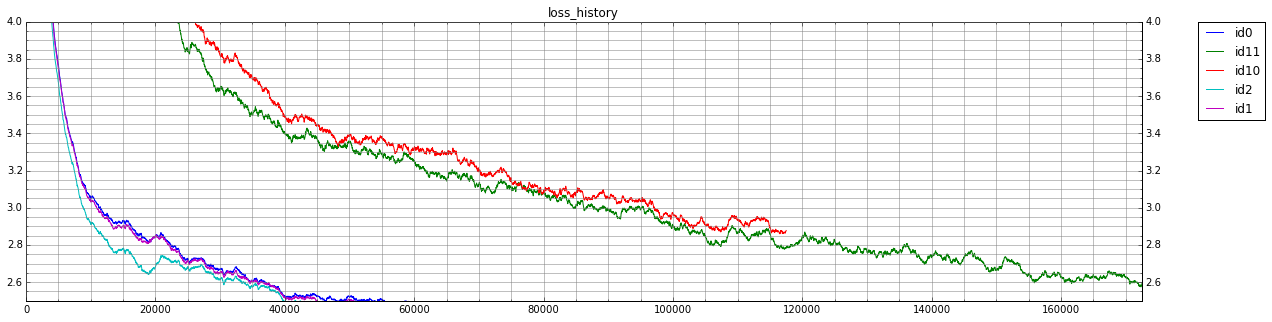

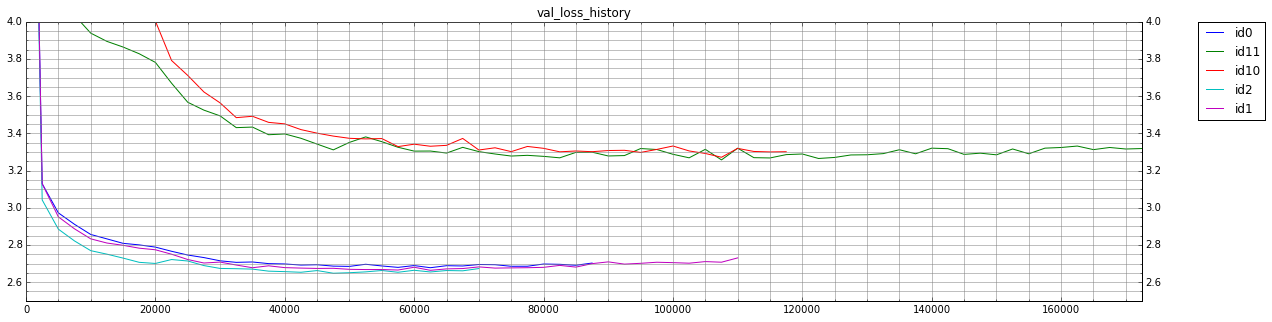

In [12]:
dataset = 'refcoco_licheng'
files = os.listdir(osp.join('../model', dataset))
jsons = [x for x in files if x[-4:] == 'json']
print 'number of jsons: ', len(jsons)

blobs = [json.load(open(osp.join('../model', dataset, jp))) for jp in jsons]
print 'loaded ', len(blobs)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colornames = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for key in ['loss_history', 'val_loss_history']:
    # draw the training loss functions
    plt.figure(figsize=(20,5))
    maxx = 0
    for ic, b in enumerate(blobs):
        xs = sorted([int(x) for x in b[key].keys()])
        ys = [b[key][str(x)] for x in xs]
        ys = smooth(ys,{'loss_history':0.99, 'val_loss_history':0, 'val_lang':0}[key])
        c = colors[ic]
        plt.plot(xs,ys,'-'+c, label='id'+str(b['opt']['id']))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        maxx = max(maxx, max(xs))
    plt.title(key)

    
    if 'loss' in key:
        plt.axis([0, maxx, 2.5, 4.0])
#    if 'lang' in key:
#        plt.axis([0, maxx, 0.8, 0.9])
    ax = plt.gca()
    ax.minorticks_on()
    ax.grid(b=True, which='both', color='gray', linestyle='-')
    ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
    
for ic, b in enumerate(blobs):
    print('%s: id%s' % (colornames[ic], b['opt']['id']))

In [13]:
# find the best performance for each blob
for b in blobs:
    xs = sorted([int(x) for x in b['val_loss_history'].keys()])
    ys = [b['val_loss_history'][str(x)] for x in xs]
    b['best_val'] = min(ys)

# find all the keys that were being cross-validated
ban = ['gpuid', 'seed', 'id']
keys = list(set(k for k in b['opt'] for b in blobs))
cvd = []
for k in keys:
    if k in ban: continue
    vals = list(set(b['opt'][k] for b in blobs if k in b['opt']))
    if len(vals) > 1: cvd.append(k)
print 'cross-validated: '
print cvd

# print params
key_params =cvd
for ic, b in enumerate(blobs):
    print('\n id%s [%s], best_val[%.2f]' % (b['opt']['id'], colornames[ic], b['best_val']))
    pprint({k:b['opt'][k] for k in b['opt'] if k in key_params})

cross-validated: 
[u'ranking_weight', u'jemb_use_global']

 id0 [blue], best_val[2.68]
{u'jemb_use_global': 1, u'ranking_weight': 0}

 id11 [green], best_val[3.26]
{u'jemb_use_global': 0, u'ranking_weight': 2}

 id10 [red], best_val[3.27]
{u'jemb_use_global': 1, u'ranking_weight': 2}

 id2 [cyan], best_val[2.65]
{u'jemb_use_global': 1, u'ranking_weight': 0}

 id1 [magenta], best_val[2.66]
{u'jemb_use_global': 0, u'ranking_weight': 0}


In [24]:

# print the best blobs in order
bs = [(b['best_val'], b['opt']) for b in blobs]
bs.sort()
print_keys = cvd + ['cnn_optim', 'id']
for vb in bs[:50]:
    s = ', '.join( '(%s: %s)' % (k, vb[1].get(k, '')) for k in print_keys)
    print '%f: %s' % (vb[0], s)
    print '----------------------------------------------------------'

2.648243: (ranking_weight: 0), (jemb_use_global: 1), (cnn_optim: adam), (id: 2)
----------------------------------------------------------
2.663885: (ranking_weight: 0), (jemb_use_global: 0), (cnn_optim: adam), (id: 1)
----------------------------------------------------------
2.677865: (ranking_weight: 0), (jemb_use_global: 1), (cnn_optim: adam), (id: 0)
----------------------------------------------------------
3.257501: (ranking_weight: 2), (jemb_use_global: 0), (cnn_optim: adam), (id: 11)
----------------------------------------------------------
3.271698: (ranking_weight: 2), (jemb_use_global: 1), (cnn_optim: adam), (id: 10)
----------------------------------------------------------
